# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def load_result(path, **kwargs):
    summary_files = [f for f in os.listdir(path) if f.startswith('summaries_')]
    ranks = len(summary_files)
    rate = 0
    for summary_file in summary_files:
        with np.load(os.path.join(path, summary_file)) as f:
            rate += f['train_rate'].mean()
    return dict(rate=rate, ranks=ranks, **kwargs)

def load_results(results_dir, hw, sw):
    results = []
    for path in os.listdir(results_dir):
        match = re.match('%s-%s-n[0-9]*' % (hw, sw), path)
        if match is not None:
            result_path = os.path.join(results_dir, path)
            # Use all models available
            models = os.listdir(result_path)
            for model in models:
                path = os.path.join(result_path, model)
                results.append(load_result(path, sw=sw, hw=hw, model=model))
    return pd.DataFrame(results)

def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of nodes')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.semilogx(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
hw = 'hsw'
sw = 'v1.2.0'

results_dir = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/'

In [6]:
# Load the results and remove missing data
results = load_results(results_dir=results_dir, hw=hw, sw=sw)
results = results[results.ranks != 0]

In [7]:
results

,hw,model,ranks,rate,sw
0,hsw,inceptionV3,32,349.357240,v1.2.0
1,hsw,lstm,32,10316.834171,v1.2.0
2,hsw,alexnet,32,3780.318802,v1.2.0
3,hsw,resnet50,32,377.922649,v1.2.0
4,hsw,vgg11,32,406.741331,v1.2.0
5,hsw,cnn3d,32,5686.896467,v1.2.0
6,hsw,inceptionV3,64,680.357056,v1.2.0
7,hsw,lstm,64,20028.229679,v1.2.0
8,hsw,alexnet,64,5482.442359,v1.2.0
9,hsw,resnet50,64,758.325380,v1.2.0


## Plot throughput scaling

In [9]:
# Let's temporarily restrict the scaling to 64 nodes
results = results[results.ranks <= 64]

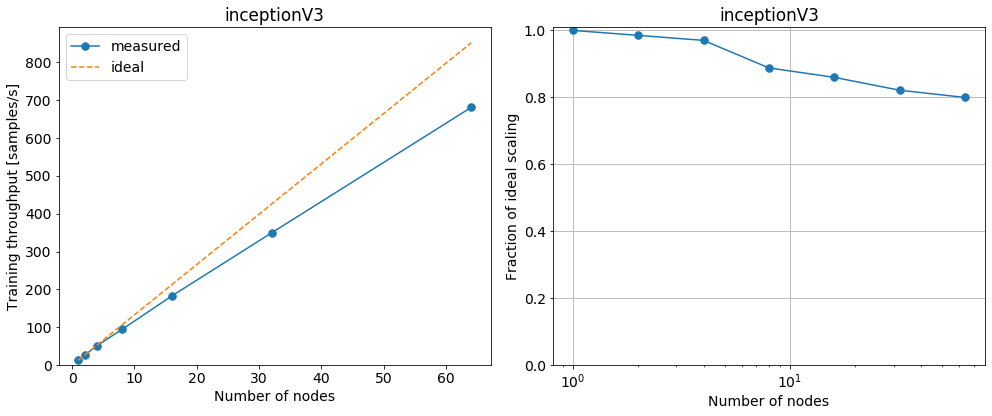

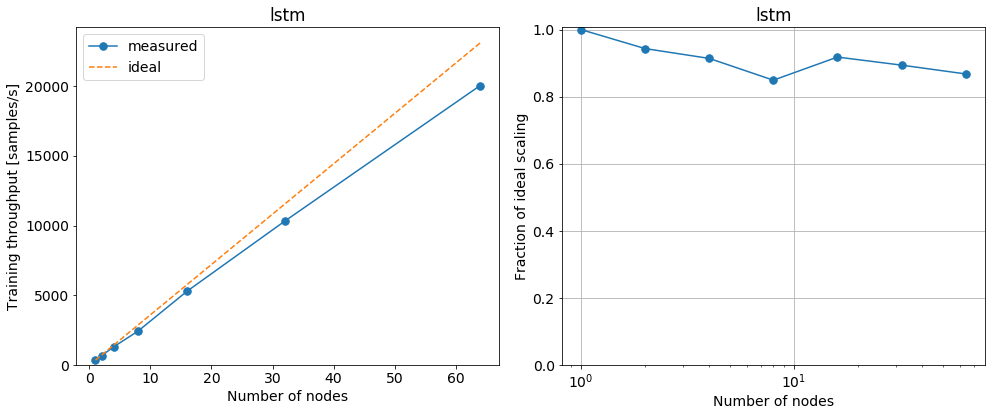

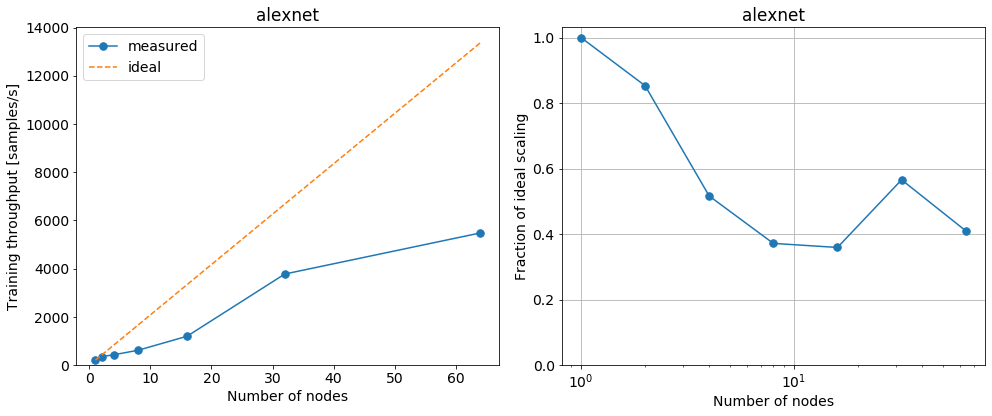

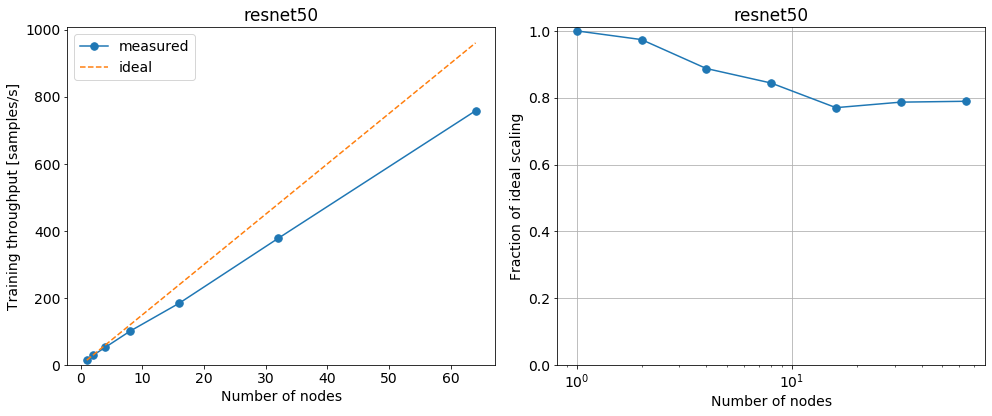

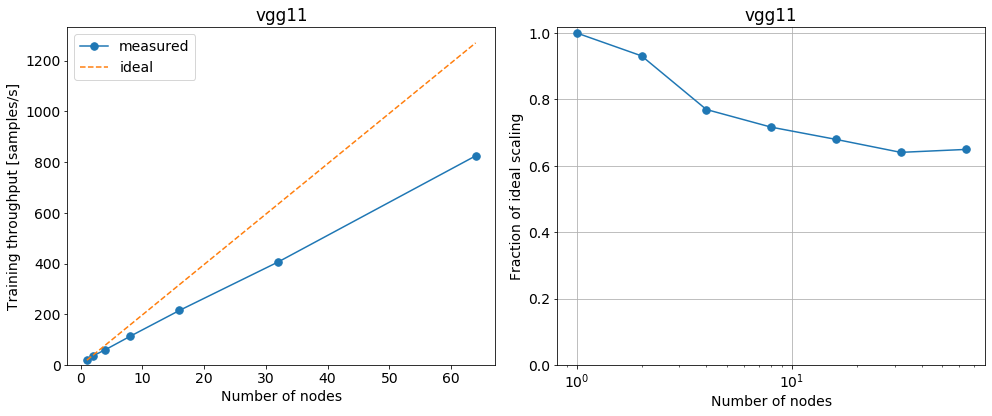

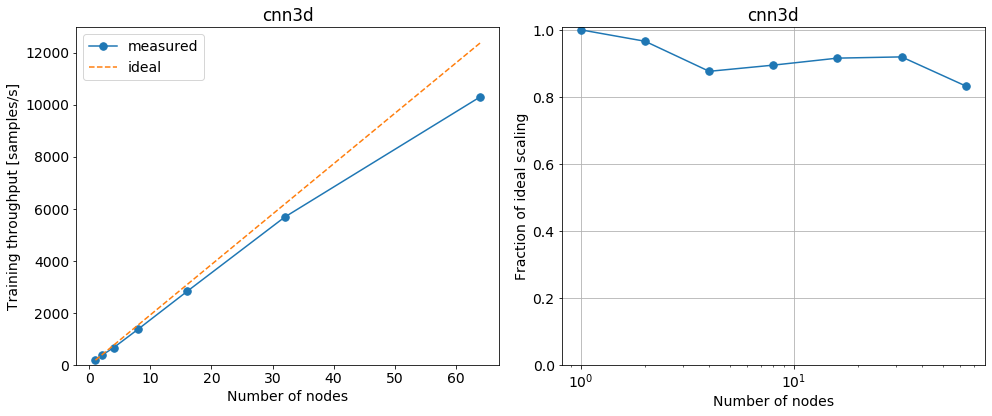

In [10]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values, model_results.rate.values, title=model)